In [1]:
import sys
import pandas as pd
import warnings
import seaborn as sns
from typing import List, Union
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import (norm, expon, lognorm, anderson, kstest, chi2,
                         chi2_contingency, t, beta)
from scipy.stats import norm, probplot
import scipy.stats as stats


import numpy as np

sys.path.append('functions')
from data_frame_handler import DataFrameHandler as dfh

# main path to file with data. Can be easily changed
file_path = 'data/urine_test_data.csv'

Data Prep

In [2]:
df = dfh.read_csv_data(file_path)

# Use a list comprehension to dynamically select matching columns
organisms = dfh.select_columns_by_search_terms(df, ['organism'])
genes = dfh.select_columns_by_search_terms(df, ['gene'])
antibiotics = dfh.select_columns_by_search_terms(df, ['antibiotic'])

# Set the 'Type' column to the values in gene_data_str - FUTURE Labels
gene_data_str = df[genes].applymap(str).agg(''.join, axis=1)
df['Type'] = gene_data_str

Select Data

In [3]:
column_name = 'Organism_1'
odata = df[column_name]
#odata = df[df[column_name] > 0][column_name]

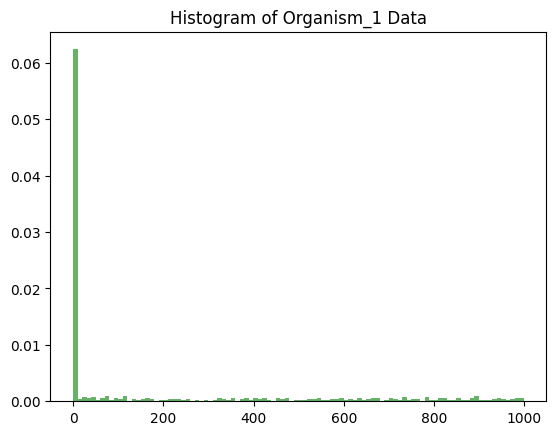

In [4]:
# 1. Data Visualization using Histogram
plt.hist(odata, bins=100, density=True, alpha=0.6, color='g')
plt.title(f"Histogram of {column_name} Data")
plt.show()

This data is not standard-normal. Let's look for a better distribution

Fit Distributions

In [5]:
# 2. Statistical Tests
# Anderson-Darling Test for multiple distributions
result = anderson(odata)
print("Anderson-Darling test result for Normal:", result.statistic)
for i in range(len(result.critical_values)):
    sig, crit = result.significance_level[i], result.critical_values[i]
    if result.statistic < crit:
        print(f'    {sig}% significance: Data looks normal (fail to reject H0)')
    else:
        print(f'    {sig}% significance: Data does not look normal (reject H0)')

Anderson-Darling test result for Normal: 155.42471722398568
    15.0% significance: Data does not look normal (reject H0)
    10.0% significance: Data does not look normal (reject H0)
    5.0% significance: Data does not look normal (reject H0)
    2.5% significance: Data does not look normal (reject H0)
    1.0% significance: Data does not look normal (reject H0)


In [6]:
# 3. Parameter Estimation for different distributions

# Normal Distribution
params_norm = norm.fit(odata)

# Exponential Distribution
params_expon = expon.fit(odata)

# Log-normal Distribution
params_lognorm = lognorm.fit(odata)

# T-distribution
params_t = t.fit(odata)

# Beta distribution
params_beta = beta.fit(odata)

# 4. Goodness of Fit Comparison using Kolmogorov-Smirnov test
ks_stat_norm, ks_p_norm = kstest(odata, 'norm', args=params_norm)
ks_stat_expon, ks_p_expon = kstest(odata, 'expon', args=params_expon)
ks_stat_lognorm, ks_p_lognorm = kstest(odata, 'lognorm', args=params_lognorm)
ks_stat_t, ks_p_t = kstest(odata, 't', args=params_t)
ks_stat_beta, ks_p_beta = kstest(odata, 'beta', args=params_beta)

print("K-S test results:")
print(f"Normal:      statistic={ks_stat_norm:.5f}, p-value={ks_p_norm}")
print(f"Exponential: statistic={ks_stat_expon:.5f}, p-value={ks_p_expon}")
print(f"Log-Normal:  statistic={ks_stat_lognorm:.5f}, p-value={ks_p_lognorm}")
print(f"T-dist:      statistic={ks_stat_t:.5f}, p-value={ks_p_t}")
print(f"Beta dist:   statistic={ks_stat_beta:.5f}, p-value={ks_p_beta}")

K-S test results:
Normal:      statistic=0.35365, p-value=2.2149247498683016e-112
Exponential: statistic=0.62000, p-value=0.0
Log-Normal:  statistic=0.61558, p-value=0.0
T-dist:      statistic=0.48630, p-value=2.272455611002191e-218
Beta dist:   statistic=0.62000, p-value=0.0


/usr/local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


Interpretation remains the same: higher p-values indicate that the observed data are not 
consistent with the any of the proposed distributions.

Show Q-Q fit plots

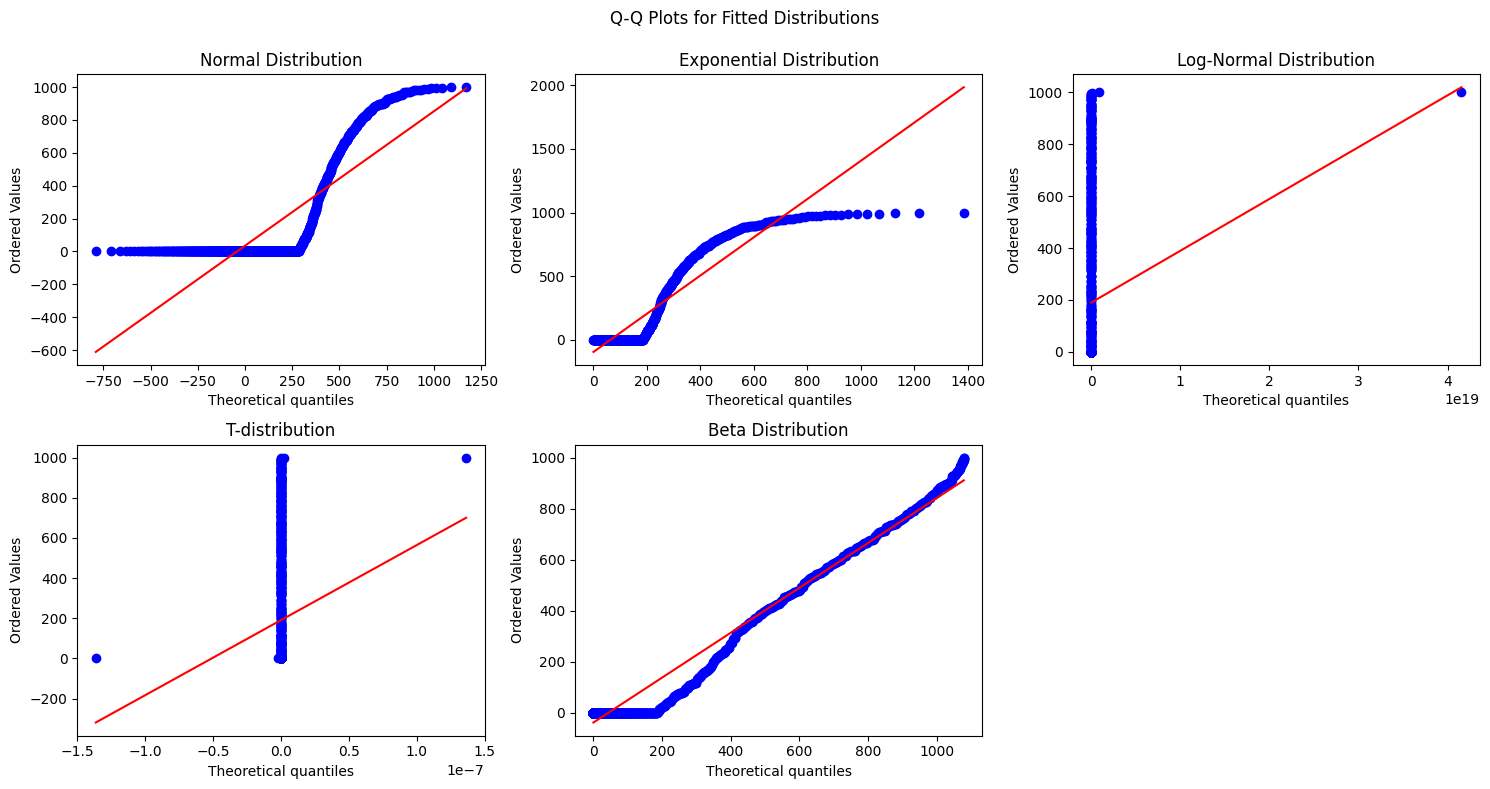

In [7]:
from scipy.stats import probplot, norm, expon, lognorm, t, beta, kstest

# Generate or load your data (odata) here
# Replace this with your actual data

# Fit different distributions to your data
params_norm = norm.fit(odata)
params_expon = expon.fit(odata)
params_lognorm = lognorm.fit(odata)
params_t = t.fit(odata)
params_beta = beta.fit(odata)

# Create a figure with subplots for Q-Q plots
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Q-Q Plots for Fitted Distributions")

# Q-Q plot for the Normal distribution
probplot(odata, dist=norm, sparams=params_norm, plot=axs[0, 0])
axs[0, 0].set_title("Normal Distribution")

# Q-Q plot for the Exponential distribution
probplot(odata, dist=expon, sparams=params_expon, plot=axs[0, 1])
axs[0, 1].set_title("Exponential Distribution")

# Q-Q plot for the Log-Normal distribution
probplot(odata, dist=lognorm, sparams=params_lognorm, plot=axs[0, 2])
axs[0, 2].set_title("Log-Normal Distribution")

# Q-Q plot for the T-distribution
probplot(odata, dist=t, sparams=params_t, plot=axs[1, 0])
axs[1, 0].set_title("T-distribution")

# Q-Q plot for the Beta distribution
probplot(odata, dist=beta, sparams=params_beta, plot=axs[1, 1])
axs[1, 1].set_title("Beta Distribution")

# Remove the empty subplot
fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the Q-Q plots
plt.show()

Q-Q plots support previous intrepretation. Though Beta distribution may be worth investigating.

Let's try some Zero-Inflated models

Optimization terminated successfully.
         Current function value: 43.433970
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                       y   No. Observations:                 1000
Model:             ZeroInflatedPoisson   Df Residuals:                      999
Method:                            MLE   Df Model:                            0
Date:                 Thu, 14 Sep 2023   Pseudo R-squ.:               2.837e-13
Time:                         19:34:25   Log-Likelihood:                -43434.
converged:                        True   LL-Null:                       -43434.
Covariance Type:             nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const     0.4895

/usr/local/lib/python3.8/site-packages/statsmodels/discrete/count_model.py:638: RuntimeWarning: overflow encountered in square
  coeff**2)).sum() - (mu[nonzero_idx] * self.exog[nonzero_idx, i] *
/usr/local/lib/python3.8/site-packages/statsmodels/discrete/count_model.py:638: RuntimeWarning: overflow encountered in square
  coeff**2)).sum() - (mu[nonzero_idx] * self.exog[nonzero_idx, i] *


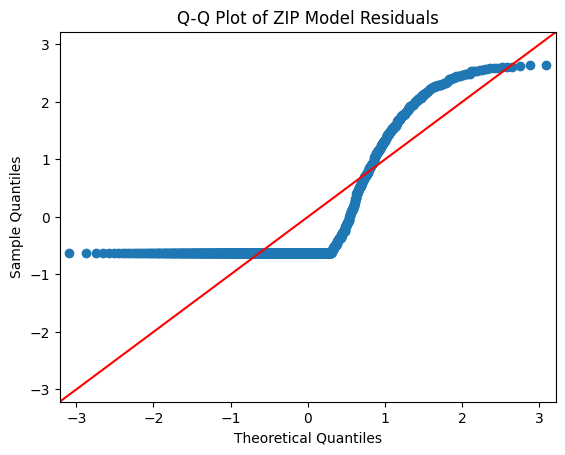

In [8]:
import statsmodels.api as sm

# Assuming 'odata' is your data series
y = odata.values

# Using a constant model for simplicity
X = np.ones((len(y), 1))

zip_model = sm.ZeroInflatedPoisson(y, X).fit()
print(zip_model.summary())

# Calculate the residuals manually
predicted_counts = zip_model.predict()
residuals = y - predicted_counts

# Create a Q-Q plot for the residuals
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of ZIP Model Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

In [9]:
import statsmodels.api as sm

# Assuming 'odata' is your data series
y = odata.values

# Using a constant model for simplicity
X = np.ones((len(y), 1))

zinb_model = sm.ZeroInflatedNegativeBinomialP(y, X).fit()
print(zinb_model.summary())

# Calculate the residuals manually
predicted_counts = zinb_model.predict()
residuals = y - predicted_counts

# # Create a Q-Q plot for the residuals
# sm.qqplot(residuals, line='45', fit=True)
# plt.title("Q-Q Plot of ZINB Model Residuals")
# plt.xlabel("Theoretical Quantiles")
# plt.ylabel("Sample Quantiles")
# plt.show()

         Current function value: nan
         Iterations: 22
         Function evaluations: 136
         Gradient evaluations: 136
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                                 y   No. Observations:                 1000
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      999
Method:                                      MLE   Df Model:                            0
Date:                           Thu, 14 Sep 2023   Pseudo R-squ.:                     nan
Time:                                   19:34:25   Log-Likelihood:                    nan
converged:                                 False   LL-Null:                       -3387.1
Covariance Type:                       nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

/usr/local/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3935: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3972: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:4325: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3935: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3972: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3975: RuntimeWarning: invalid value encountered in multip

Looks like the Zero-Regressions aren't great. 

Let's look closely at 2 transformations

A. CLT

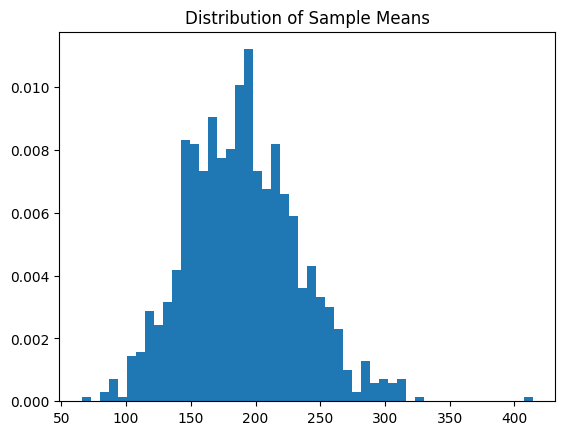

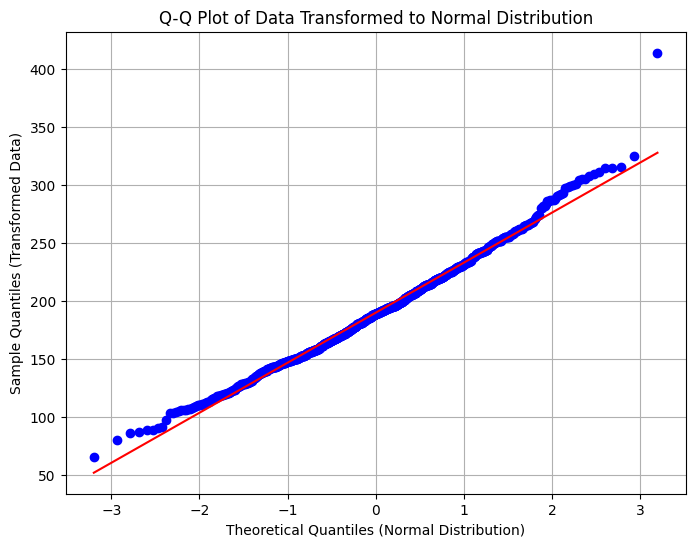

K-S Norm: statistic=0.03284, p-value=0.22599454703547384


In [12]:
# Assuming 'odata' has been defined as your dataset
sample_means = []

n = 50  # Size of each sample
samples = 1000  # Number of samples

for _ in range(samples):
    sample = np.random.choice(odata, n)
    sample_means.append(np.mean(sample))

plt.hist(sample_means, bins=50, density=True)
plt.title('Distribution of Sample Means')
plt.show()

# Create a Q-Q plot to visualize the transformation to a normal distribution
plt.figure(figsize=(8, 6))
stats.probplot(sample_means, dist="norm", plot=plt)
plt.title("Q-Q Plot of Data Transformed to Normal Distribution")
plt.xlabel("Theoretical Quantiles (Normal Distribution)")
plt.ylabel("Sample Quantiles (Transformed Data)")
plt.grid(True)
plt.show()


# Normal Distribution
# 4. Goodness of Fit Comparison using Kolmogorov-Smirnov test
params_norm = norm.fit(sample_means)
ks_stat_norm, ks_p_norm = kstest(sample_means, 'norm', args=params_norm)
print(f"K-S Norm: statistic={ks_stat_norm:.5f}, p-value={ks_p_norm}")

Based on the high number of 0's in the data, LogTranformation and BoxCox are not appropriate.

B. Beta distr

/usr/local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


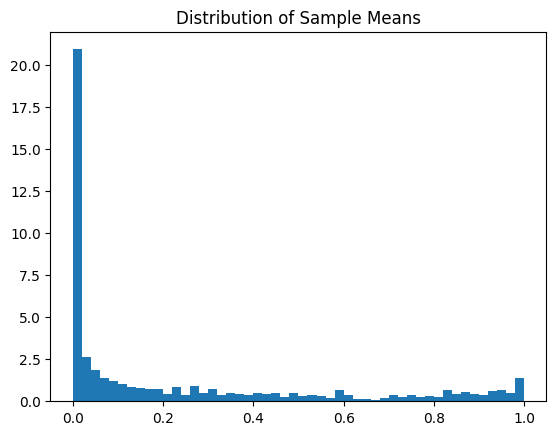

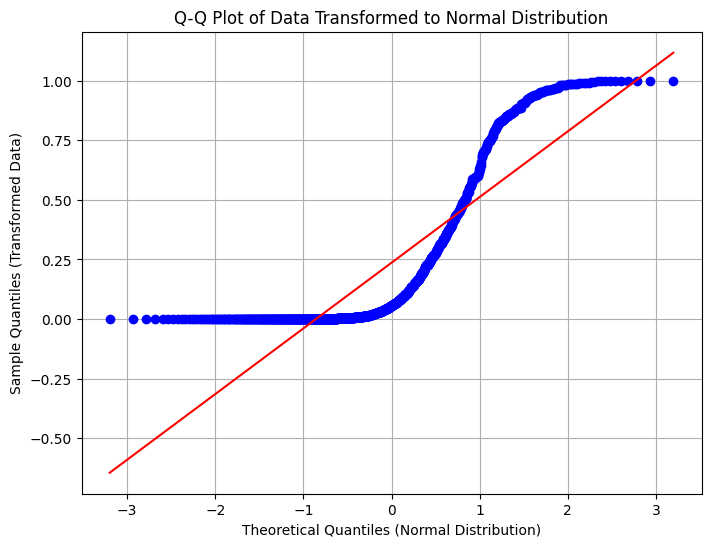

In [11]:
# Fit a Beta distribution to the data
params = beta.fit(odata)

# Generate synthetic data from a Beta distribution with the same parameters
synthetic_data = stats.beta.rvs(params[0], params[1], size=len(odata))

plt.hist(synthetic_data, bins=50, density=True)
plt.title('Distribution of Sample Means')
plt.show()

# Create a Q-Q plot to visualize the transformation to a normal distribution
plt.figure(figsize=(8, 6))
stats.probplot(synthetic_data, dist="norm", plot=plt)
plt.title("Q-Q Plot of Data Transformed to Normal Distribution")
plt.xlabel("Theoretical Quantiles (Normal Distribution)")
plt.ylabel("Sample Quantiles (Transformed Data)")
plt.grid(True)
plt.show()

Conclusion:
There isn't an apparent easily defined distribution for Organism 1 cell counts. 
Given the similarity of the data between organisms, we can assume (for sake of time) that all distributions will be similar.
I recommend that since we are going to be doing PCA, among other methods, that data be transformed in some fashion. While PCA makes no assumptions on background distribution, the scaling step prior to performing a PCA does.
Using CLT prior to running those analyses may not be appropriate, but warants further discussion.